# NYPD Motor Vehicle Collision Data<a id='Top'></a>

### Overview

The "Motor Vehicle Collisions - Crashes" dataset available through New York City's Open Data program contains information about reported vehicle crashes in NYC. Each row contains details on a single crash event. 

The data contains records from 2012 to today, with data updated on a daily basis. At the time of this writing, there are 1.61 million rows, each row representing a crash event, and 29 columns. 

In this notebook we will analyze this data as follows:

1. [Importing](#Importing)
4. [Analyzing](#Analyzing)
5. [Statistical Analysis](#statistical_analysis)
    - [ANOVA](#anova)
    - [2 Sample T-Test](#2ttest)
    - [Chi-Square](#chi-sq)
6. [Visualizing](#Visualizations)
    - [Number of Deaths by Borough](#Fataities_by_borough) 
    - [Number of Crashes by Hour](#Crashes_by_hour)
    - [Number of Accidents by Season](#accidents_by_season)
    - [Fatal Car Crash Locations](#car_crash_locations)
    - [Contributing Factor Trends](#contributing_factor_trends)
    - [Contributing Factors to Crash Fatalities](#Factor_Bar_Plot)
    - [Fatalities to Pedestrians vs Cyclists vs Motorist](#Fataity_Grouped_Series)
    - [Fatal Crash Frequency Over Time](#Fatality_Time_Scatterplot)
    - [Crash Factor Percentages in Queens](#queens_crash_causes)
7. [End of Document](#Bottom)


* The dataset can be found by following this link: https://data.cityofnewyork.us/Public-Safety/NYPD-Motor-Vehicle-Collisions-Crashes/h9gi-nx95

### Importing the Data<a id='Importing'></a>

We'll being by making sure we import our cleaned data from the csv in this folder.

<br><div style="text-align: right">[Begining of the page](#Top)</div>

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import sys
from IPython.core.display import display, HTML

In [2]:
clean_nyc1 = pd.read_csv('nyc_crash_data.csv')

/Users/leidner/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


And let's also pull up the data dictionary again for reference.

In [3]:
data_dict = pd.read_excel("https://data.cityofnewyork.us/api/views/h9gi-nx95/files/2e58023a-21a6-4c76-b9e8-0101bf7509ca?download=true&filename=MVCollisionsDataDictionary.xlsx",
                         sheet_name='Column Info',  header=1)
data_dict.head(30)

,Table Name,Column Name,Column Description,Primary Key or Foreign Key,"Additional Notes (where applicable, includes the range of possible values, units of measure, how to interpret null/zero values, whether there are specific relationships between columns, and/or information on column source)"
0,MV-Collisions - Crash,UNIQUE_ID,Unique record code generated by system,Primary Key for the crash table,NaN
1,MV-Collisions - Crash,ACCIDENT_DATE,Occurrence date of collision,NaN,NaN
2,MV-Collisions - Crash,ACCIDENT_TIME,Occurrence time of collision,NaN,NaN
3,MV-Collisions - Crash,BOROUGH,Borough where collision occurred,NaN,NaN
4,MV-Collisions - Crash,ZIP CODE,Postal code of incident occurrence,NaN,NaN
5,MV-Collisions - Crash,LATITUDE,Latitude coordinate for Global Coordinate Syst...,NaN,NaN
6,MV-Collisions - Crash,LONGITUDE,Longitude coordinate for Global Coordinate Sys...,NaN,NaN
7,MV-Collisions - Crash,LOCATION,"Latitude , Longitude pair",NaN,NaN
8,MV-Collisions - Crash,ON STREET NAME,Street on which the collision occurred,NaN,NaN
9,MV-Collisions - Crash,CROSS STREET NAME,Nearest cross street to the collision,NaN,NaN


## Analyzing the data <a id='Analyzing'></a>
<br><div style="text-align: right">[Begining of the page](#Top)</div>

Let's see how many cyclists, pedestrians and motorists were killed in all of our collisions. First, we will create a dataframe that extracts the rows where fatalities occurred. Then we will use the same process to extract the differenct categories of people, as defined by the data dictionary, and create a new column which creates a cumulative sum of the number of people killed.

In [4]:
lethal_crashes = clean_nyc1[clean_nyc1['persons_killed'] > 0]
lethal_crashes.head()

,crash_date,crash_time,borough,zip_code,latitude,longitude,persons_injured,persons_killed,pedestrians_injured,pedestrians_killed,cyclist_injured,cyclist_killed,motorist_injured,motorist_killed,contributing_factor_vehicle_1,contributing_factor_vehicle_2,vehicle_type_code_1,vehicle_type_code_2,hour,season
3328,2019-12-02 00:00:00,2019-12-10 17:52:00,NaN,NaN,40.616295,-73.92991,0.0,1.0,0,0,0,0,0,1,illness,NaN,tow truck / wrecker,NaN,17,Winter
4733,2019-11-09 00:00:00,2019-12-10 02:33:00,NaN,NaN,40.801754,-73.93121,0.0,1.0,0,0,0,1,0,0,road defects,unspecified,dump,bike,2,Autumn
5945,2019-11-29 00:00:00,2019-12-10 08:45:00,queens,11377,40.746048,-73.89903,0.0,1.0,0,1,0,0,0,0,traffic recklessness,NaN,suv,NaN,8,Autumn
6463,2019-12-02 00:00:00,2019-12-10 17:52:00,NaN,NaN,40.616295,-73.92991,0.0,1.0,0,0,0,0,0,1,illness,NaN,towe,NaN,17,Winter
6742,2019-11-09 00:00:00,2019-12-10 00:58:00,NaN,NaN,40.845190,-73.91120,0.0,1.0,0,0,0,0,0,1,traffic recklessness,unspecified,tractor truck diesel,taxi,0,Autumn


In [5]:
killed_motorists = lethal_crashes.groupby(['crash_date','borough']).motorist_killed.sum().reset_index()
killed_motorists['sum'] = killed_motorists['motorist_killed'].cumsum()

killed_cyclist = lethal_crashes.groupby(['crash_date','borough']).cyclist_killed.sum().reset_index()
killed_cyclist['sum'] = killed_cyclist['cyclist_killed'].cumsum()

killed_pedestrians = lethal_crashes.groupby(['crash_date','borough']).pedestrians_killed.sum().reset_index()
killed_pedestrians['sum'] = killed_pedestrians['pedestrians_killed'].cumsum()

killed_persons = lethal_crashes.groupby(['crash_date','borough']).persons_killed.sum().reset_index()
killed_persons['sum'] = killed_persons['persons_killed'].cumsum()

We will now display the last line of each of these data sets to find out how many people were killed.

In [6]:
killed_motorists.tail(1)

,crash_date,borough,motorist_killed,sum
684,2019-11-29 00:00:00,queens,0,287


In [7]:
killed_pedestrians.tail(1)

,crash_date,borough,pedestrians_killed,sum
684,2019-11-29 00:00:00,queens,1,391


In [8]:
killed_cyclist.tail(1)

,crash_date,borough,cyclist_killed,sum
684,2019-11-29 00:00:00,queens,0,72


In [9]:
killed_persons.tail(1)

,crash_date,borough,persons_killed,sum
684,2019-11-29 00:00:00,queens,1.0,751.0


It looks like being a pedestrian is much more dangerous than being a motorist in NYC (not taking into account the per capita numbers).

Astute readers will note that these numbers dont add up exactly. The counts of killed motorists + cyclists + pedestrians _should_ equal the count of killed persons. However, these numbers are only 1 off, so we will assume that there was a minor recording error somewhere.

What about injured people? We'll do the same as above (excluding the borough column, which we will not reference later).

In [10]:
crashes_with_injuries = clean_nyc1[clean_nyc1['persons_injured'] > 0]
crashes_with_injuries.head()

,crash_date,crash_time,borough,zip_code,latitude,longitude,persons_injured,persons_killed,pedestrians_injured,pedestrians_killed,cyclist_injured,cyclist_killed,motorist_injured,motorist_killed,contributing_factor_vehicle_1,contributing_factor_vehicle_2,vehicle_type_code_1,vehicle_type_code_2,hour,season
4,2018-12-26 00:00:00,2019-12-10 13:13:00,NaN,NaN,NaN,NaN,2.0,0.0,0,0,0,0,2,0,traffic recklessness,unspecified,suv,van,13,Winter
10,2015-01-13 00:00:00,2019-12-10 16:03:00,NaN,NaN,40.715722,-73.825733,1.0,0.0,0,0,0,0,1,0,driver inattention/distraction,NaN,taxi,NaN,16,Winter
13,2015-01-13 00:00:00,2019-12-10 02:10:00,NaN,NaN,40.604873,-74.029540,1.0,0.0,0,0,0,0,1,0,drugs (illegal),NaN,passenger vehicle,NaN,2,Winter
24,2019-09-26 00:00:00,2019-12-10 10:11:00,NaN,NaN,NaN,NaN,1.0,0.0,0,0,0,0,1,0,traffic recklessness,unspecified,sedan,sedan,10,Autumn
28,2019-12-03 00:00:00,2019-12-10 18:22:00,NaN,NaN,40.627310,-73.941826,1.0,0.0,1,0,0,0,0,0,traffic recklessness,NaN,sedan,NaN,18,Winter


In [11]:
injured_motorists = crashes_with_injuries.groupby('crash_date').motorist_injured.sum().reset_index()
injured_motorists['sum'] = injured_motorists['motorist_injured'].cumsum()

injured_cyclist = crashes_with_injuries.groupby('crash_date').cyclist_injured.sum().reset_index()
injured_cyclist['sum'] = injured_cyclist['cyclist_injured'].cumsum()

injured_pedestrians = crashes_with_injuries.groupby('crash_date').pedestrians_injured.sum().reset_index()
injured_pedestrians['sum'] = injured_pedestrians['pedestrians_injured'].cumsum()

injured_persons = crashes_with_injuries.groupby('crash_date').persons_injured.sum().reset_index()
injured_persons['sum'] = injured_persons['persons_injured'].cumsum()

In [12]:
injured_motorists.tail(1)

,crash_date,motorist_injured,sum
2715,2019-12-07 00:00:00,107,214723


In [13]:
injured_pedestrians.tail(1)

,crash_date,pedestrians_injured,sum
2715,2019-12-07 00:00:00,20,45597


In [14]:
injured_cyclist.tail(1)

,crash_date,cyclist_injured,sum
2715,2019-12-07 00:00:00,6,22687


In [15]:
injured_persons.tail(1)

,crash_date,persons_injured,sum
2715,2019-12-07 00:00:00,133.0,283080.0


Interesting! It looks like motorists get injured 4 times as much as pedestrians in car crashes! This is a stark contrast to our fatality data, where pedestrians were more likely to be killed than motorists.

We'll now turn our attention to see which boroughs have a high number of collisions.

In [16]:
clean_nyc1['borough'].value_counts()

brooklyn         191963
queens           184380
manhattan        179246
bronx             86307
staten island     28090
Name: borough, dtype: int64

A lot of collisions in Brooklyn! And suprisingly few in The Bronx and Staten Island.

Let's see the common reasons behind collisions.

In [17]:
clean_nyc1.contributing_factor_vehicle_1.value_counts()

traffic recklessness              451751
driver inattention/distraction    367978
road defects                       60758
outside error                      57014
illness                            47246
car defects                        19346
drugs (illegal)                    16261
Name: contributing_factor_vehicle_1, dtype: int64

'Traffic recklessness' and 'driver inattention/distraction' are the main causes of collisions. 

What about the vehicle types? We will first make a copy of data -- a whole new data frame named `contributing_factor` to see the common vehicle types involved in driver inattention/distraction caused collisions.

In [19]:
contributing_factor_inattention = clean_nyc1[clean_nyc['contributing_factor_vehicle_1'] == "Driver Inattention/Distraction"].copy()
contributing_factor_inattention.head()

,crash_date,crash_time,borough,zip_code,latitude,longitude,persons_injured,persons_killed,pedestrians_injured,pedestrians_killed,cyclist_injured,cyclist_killed,motorist_injured,motorist_killed,contributing_factor_vehicle_1,contributing_factor_vehicle_2,vehicle_type_code_1,vehicle_type_code_2,hour,season


Now we can see which vehicles have the 'Driver Inattention' factor most frequently.

In [ ]:
contributing_factor_inattention['vehicle_type_code_1'].value_counts().head(30)

Passenger vehicles take the lead in terms of vehicles most commonly involved in 'driver inattention/distraction' caused collisions. They are followed by SUVs.

## Statistical Analysis <a id='statistical_analysis'></a>
<br><div style="text-align: right">[Begining of the page](#Top)</div>

Our analysis found a lot of interesting points, but at a glance, it is hard to tell if we just got lucky with our data. Was it a random chance that gave us our points of interest, or are these differences real? To find out, we will perform some statistical analyses!

### ANOVA <a id='anova'></a>

We will begin by looking at whether there is a difference between the number of deaths by borough for persons, pedestrians, motorists and cyclists. We will use one way ANOVA test for that since we have more than two boroughs (more than two nominal variables).

We will first drop the NaN's in the `persons_killed` column to be able to do the ANOVA test.

In [20]:
from scipy import stats

clean_nyc1.dropna(subset = ['persons_killed'], how='all', inplace=True)

stats.f_oneway(clean_nyc1[['persons_killed']][clean_nyc1['borough']=="manhattan"],
              clean_nyc1[['persons_killed']][clean_nyc1['borough']=="staten island"],
              clean_nyc1[['persons_killed']][clean_nyc1['borough']=="bronx"],
              clean_nyc1[['persons_killed']][clean_nyc1['borough']=="queens"],
              clean_nyc1[['persons_killed']][clean_nyc1['borough']=="brooklyn"])

F_onewayResult(statistic=array([6.18236289]), pvalue=array([5.7031153e-05]))

Our p-value is less than 0.05, which means that it is statistically significant. There seems to be a difference between the number of persons killed by borough.

In [21]:
stats.f_oneway(clean_nyc1[['motorist_killed']][clean_nyc1['borough']=="manhattan"],
              clean_nyc1[['motorist_killed']][clean_nyc1['borough']=="staten island"],
              clean_nyc1[['motorist_killed']][clean_nyc1['borough']=="bronx"],
              clean_nyc1[['motorist_killed']][clean_nyc1['borough']=="queens"],
              clean_nyc1[['motorist_killed']][clean_nyc1['borough']=="brooklyn"])

F_onewayResult(statistic=array([12.3650488]), pvalue=array([4.68448789e-10]))

That is a very low p-value. We are seeing a difference. Our null hypothesis was that all of the boroughs have the same mean for the number of motorists killed in accidents. That null hypothesis is highly unlikely and one or more of these boroughs is different than the others.

In [22]:
stats.f_oneway(clean_nyc1[['cyclist_killed']][clean_nyc1['borough']=="manhattan"],
              clean_nyc1[['cyclist_killed']][clean_nyc1['borough']=="staten island"],
              clean_nyc1[['cyclist_killed']][clean_nyc1['borough']=="bronx"],
              clean_nyc1[['cyclist_killed']][clean_nyc1['borough']=="queens"],
              clean_nyc1[['cyclist_killed']][clean_nyc1['borough']=="brooklyn"])

F_onewayResult(statistic=array([1.26869851]), pvalue=array([0.27971007]))

Our p-value is greater than 0.05, which means that it is not statistically significant. There seems to be no difference in the mean number of cyclists killed by borough.

In [23]:
stats.f_oneway(clean_nyc1[['pedestrians_killed']][clean_nyc1['borough']=="manhattan"],
              clean_nyc1[['pedestrians_killed']][clean_nyc1['borough']=="staten island"],
              clean_nyc1[['pedestrians_killed']][clean_nyc1['borough']=="bronx"],
              clean_nyc1[['pedestrians_killed']][clean_nyc1['borough']=="queens"],
              clean_nyc1[['pedestrians_killed']][clean_nyc1['borough']=="brooklyn"])

F_onewayResult(statistic=array([0.73690264]), pvalue=array([0.56663094]))

Our p-value is not less than 0.05. There seems to be no difference in the number of pedestrians killed by borough.

So, there is a difference in the numbers of persons and motorists killed, but there is no difference in the numbers of pedestrians and cyclists  killed by borough.

Let's also see whether there is a difference in the numbers of persons killed by season.

In [24]:
clean_nyc1.season.unique()

array(['Winter', 'Autumn', 'Spring', 'Summer'], dtype=object)

In [25]:
stats.f_oneway(clean_nyc1[['persons_killed']][clean_nyc1['season']=="Autumn"],
              clean_nyc1[['persons_killed']][clean_nyc1['season']=="Spring"],
              clean_nyc1[['persons_killed']][clean_nyc1['season']=="Summer"],
              clean_nyc1[['persons_killed']][clean_nyc1['season']=="Winter"])

F_onewayResult(statistic=array([2.60078152]), pvalue=array([0.05027883]))

That is a very interesting p-value right on the edge! The p-value is very close to being statistically significant but not. This may suggest what we are seeing here in our sample data can't be a real difference but then again, it is very close. We can reject the null hypothesis.

ANOVA can tell there is a difference but can't tell which borough (or boroughs) is different. We need to do some comparisons to see which of the boroughs is an outlier. Let's try two-sample T-tests.

### Two-Sample T-Tests <a id='2ttest'></a>

We will begin by using two-sample T-test to measure whether numbers of motorists killed has a mean that differs between Manhattan and Staten Island. The two-sample T-test assumes that the distribution of values in each group follows a normal distribution ("bell curve"). Let's confirm that this is true for numbers of motorists killed in Manhattan and Staten Island.

In [26]:
stats.ttest_ind(clean_nyc1[['motorist_killed']][clean_nyc1['borough'] == 'manhattan'], clean_nyc1[['motorist_killed']][clean_nyc1['borough'] == 'staten island'])

Ttest_indResult(statistic=array([-7.81103523]), pvalue=array([5.6983593e-15]))

The statistic here represents the distance between the two means, in terms of standard deviations. That is a very small p-value and it is statistically significant. There is a difference between Manhattan and Staten Island. What about Brooklyn and Staten Island?

In [27]:
stats.ttest_ind(clean_nyc1[['motorist_killed']][clean_nyc1['borough'] == 'brooklyn'], clean_nyc1[['motorist_killed']][clean_nyc1['borough'] == 'staten island'])

Ttest_indResult(statistic=array([-2.9808389]), pvalue=array([0.00287491]))

Our p-value is less than 0.05, so there is a statistically significant difference. We can reject the null hypothesis (our null hypothesis was that the motorists killed means are equal in each borough).

What about Queens and Manhattan?

In [28]:
stats.ttest_ind(clean_nyc1[['motorist_killed']][clean_nyc1['borough'] == 'queens'], clean_nyc1[['motorist_killed']][clean_nyc1['borough'] == 'manhattan'])

Ttest_indResult(statistic=array([5.65229954]), pvalue=array([1.58433389e-08]))

Our p-value is very small this time! There is a little difference... but what about the effect size? Are they really that different? Let's define cohen's d to measure the effect size. Let's look at the effect size for the difference between Manhattan and Queens.

In [29]:
from numpy import var, mean
from math import sqrt
def cohens_d (first, second):
  s1, s2 = var(first, ddof=1), var(second, ddof=1)
  std = sqrt(((len(first) - 1) * s1 + (len(second) - 1) * s2) / (len(first) + len(second) - 2))
  return (mean(first)-  mean(second)) / std

In [30]:
cohens_d(clean_nyc1[['motorist_killed']][clean_nyc1['borough']=="manhattan"], 
                clean_nyc1[['motorist_killed']][clean_nyc1['borough']=="queens"])

motorist_killed   -0.018749
dtype: float64

It looks like the difference is trivial. It is a very small effect size which indicates that the difference between them is not very large.

What about the effect size for Manhattan and Staten Island?

In [31]:
cohens_d(clean_nyc1[['motorist_killed']][clean_nyc1['borough']=="manhattan"], 
                clean_nyc1[['motorist_killed']][clean_nyc1['borough']=="staten island"])

motorist_killed   -0.050125
dtype: float64

Again, the difference is trivial. It is a very small effect size which indicates that the difference between them is not statistically significant.

Next, let's see if there are statistically significant differences between the number of fatalities of different vehicle types.

In [32]:
stats.ttest_ind(clean_nyc1[['persons_killed']][clean_nyc1['vehicle_type_code_1']=="suv"], 
                clean_nyc1[['persons_killed']][clean_nyc1['vehicle_type_code_1']=="sedan"])

Ttest_indResult(statistic=array([2.95496512]), pvalue=array([0.00312722]))

It looks like SUV's are more lethal, though not enough to outlaw them. The small p-value is low enough to show that the slight difference is in fact statistically significant, and not a trick of our dataset.

We wonder though: Are SUVs even more dangerous for pedestrians? They are bigger...

In [33]:
stats.ttest_ind(clean_nyc1[['pedestrians_killed']][clean_nyc1['vehicle_type_code_1']=="suv"], 
                clean_nyc1[['pedestrians_killed']][clean_nyc1['vehicle_type_code_1']=="sedan"])

Ttest_indResult(statistic=array([4.89899377]), pvalue=array([9.63644964e-07]))

Wow!! It looks like the difference is greater, but the p-value is so small that there is almost no chance that the difference is random!

Let's see if SUVs are significantly different to the largest/broadest set of fatal vehicle types: "passenger vehicle"

In [34]:
stats.ttest_ind(clean_nyc1[['persons_injured']][clean_nyc1['vehicle_type_code_1']=="suv"], 
                clean_nyc1[['persons_injured']][clean_nyc1['vehicle_type_code_1']=="passenger vehicle"])

Ttest_indResult(statistic=array([-0.69413665]), pvalue=array([0.48759674]))

SUVs are slightly, but not significantly more fatal to all people in NYC. Now to check for pedestrians.

In [35]:
stats.ttest_ind(clean_nyc1[['pedestrians_killed']][clean_nyc1['vehicle_type_code_1']=="suv"], 
                clean_nyc1[['pedestrians_killed']][clean_nyc1['vehicle_type_code_1']=="passenger vehicle"])

Ttest_indResult(statistic=array([3.00644862]), pvalue=array([0.00264328]))

There is a statistically significant difference.

So far, we were able to determine that some vehicles are more dangerous to the lives of New Yorkers than others. We were able to point out the raw numbers, but also prove that they had statistical significance. We also found that strong evidence of how dangerous SUVs are to pedestrians in NYC.

### Chi-Square <a id='chi-sq'></a>

Chi-square, or chi-squared, is a measure of independence of categorical variables. Here we will be looking at categories like borough and season. Chi-square requires frequency counts or a contingency table.

In [36]:
contingency_table = pd.crosstab(
    clean_nyc1['borough'], clean_nyc1['season'],
    margins = True)

contingency_table

season,Autumn,Spring,Summer,Winter,All
borough,,,,,
bronx,22774,21267,23177,19088,86306
brooklyn,51269,47039,51168,42484,191960
manhattan,48918,43617,47900,38809,179244
queens,50203,44104,48837,41234,184378
staten island,7337,6622,7171,6959,28089
All,180501,162649,178253,148574,669977


In [37]:
stats.chi2_contingency(contingency_table)

(186.25835216077417,
 5.756025436011303e-29,
 20,
 array([[ 23252.02104848,  20952.33805638,  22962.43515524,
          19139.2057399 ,  86306.        ],
        [ 51716.65887038,  46601.75206015,  51072.56798368,
          42569.0210858 , 191960.        ],
        [ 48290.79392875,  43514.71372301,  47689.36953358,
          39749.12281466, 179244.        ],
        [ 49673.96399876,  44761.08481634,  49055.31329284,
          40887.63789205, 184378.        ],
        [  7567.56215363,   6819.11134412,   7473.31403466,
           6229.01246759,  28089.        ],
        [180501.        , 162649.        , 178253.        ,
         148574.        , 669977.        ]]))

Our chi-square value is 189.3 and p-value is, well, very small. It is statistically significant. That suggests that the variable season is somehow related to the variable borough. Season did influence the number of accidents in each borough.

Now, we can begin our visualizations...

## Visualizing the data <a id='Visualizations'></a>
<br><div style="text-align: right">[Begining of the page](#Top)</div>

We will create an exploratory visualization of:

* [Number of Deaths by Borough](#Fataities_by_borough)
* [Number of Deaths by Hour](#Fataities_by_hour)
* [Number of Accidents by Season](#accidents_by_season)
* [Fatal Car Crash Locations](#car_crash_locations)
* [Contributing Factor Trends](#contributing_factor_trends)
* [Contributing Factors to Crash Fatalities](#Factor_Bar_Plot)
* [Fatalities to Pedestrians vs Cyclists vs Motorist](#Fataity_Grouped_Series)
* [Fatal Crash Frequency Over Time](#Fatality_Time_Scatterplot)
* [Crash Factor Percentages in Queens](#queens_crash_causes)

### Number of deaths by borough <a id='Fataities_by_borough'></a>

Let's see the average of killed persons by borough with the collisions count.

In [38]:
killed_persons.groupby('borough').persons_killed.agg(['sum'])

,sum
borough,
bronx,97.0
brooklyn,247.0
manhattan,140.0
queens,223.0
staten island,44.0


Let's graph this with a bar chart.

Text(0.5, 0, ' ')

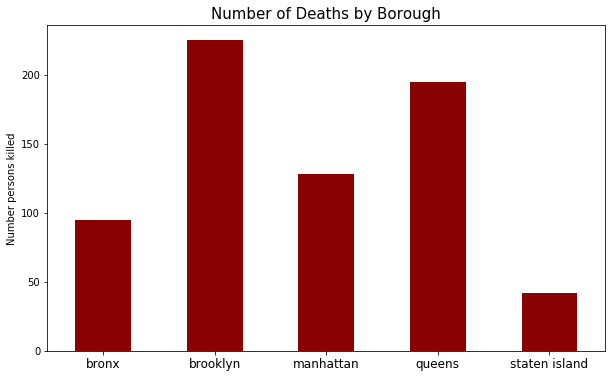

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
killed_persons.groupby('borough').persons_killed.count().plot(kind='bar', figsize=(10, 6),  color='#8a0303')
plt.ylabel('Number persons killed')
plt.title('Number of Deaths by Borough', fontsize=15)
plt.xticks(rotation=0, fontsize='large')
plt.xlabel(' ')


It looks like Brooklyn and Queens have the highest death counts, while Staten Island has the lowest. Interesting.

### Number of Crashes by Hour  <a id='Crashes_by_hour'></a>

Let's see the mean of persons killed by hour. We are interested in seeing the percentage rate of persons killed for each hour. We want to see this information hourly to get a better general idea. 

Text(0.5, 0, 'time')

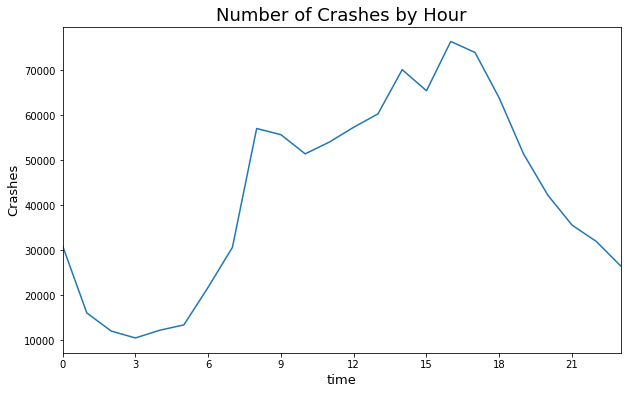

In [40]:
clean_nyc1.groupby(clean_nyc1.hour).persons_killed.count().plot(figsize=(10, 6))
plt.title('Number of Crashes by Hour', fontsize=18)
plt.ylabel('Crashes', fontsize=13)
plt.xticks(np.arange(0, 24, step=3))
plt.xlabel('time', fontsize=13)

It looks like the number of deaths go up between 14:00 and 17:00. They decrease between 2:00 and 7:00, while most people are sleeping.

### Number of crashes by season <a id='accidents_by_season'></a>

Let's see the number of car crashes by season.

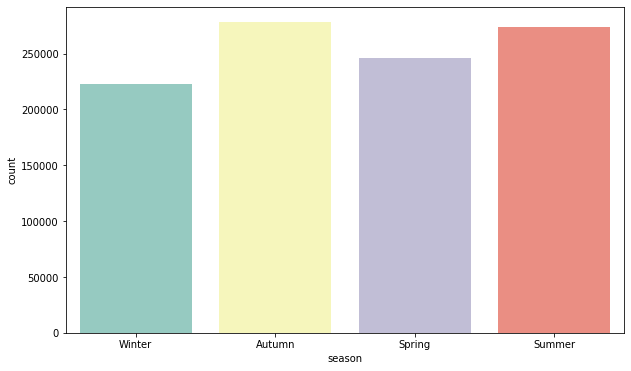

In [41]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.countplot(x='season', data=clean_nyc1, palette='Set3')

Autumn and Summer have higher number of accidents compared to Spring and Winter.

### Fatal Car Crash Locations <a id='car_crash_locations'></a>

We will have to prepare a new dataframe with the latitude and longitude values, before this can work. We'll also include other columns we may want to display in the visualization in some way, shape, or form.

In [42]:
crash_locations = clean_nyc1[['borough', 'crash_date', 'latitude' ,'longitude','persons_killed',
                           'cyclist_killed', 'pedestrians_killed','motorist_killed']].copy()
crash_locations.head()

,borough,crash_date,latitude,longitude,persons_killed,cyclist_killed,pedestrians_killed,motorist_killed
0,NaN,2015-01-15 00:00:00,NaN,NaN,0.0,0,0,0
1,NaN,2019-12-07 00:00:00,NaN,NaN,0.0,0,0,0
2,manhattan,2018-12-27 00:00:00,NaN,NaN,0.0,0,0,0
3,NaN,2019-12-06 00:00:00,NaN,NaN,0.0,0,0,0
4,NaN,2018-12-26 00:00:00,NaN,NaN,0.0,0,0,0


The first thing we will do is remove any non-fatal rows. To do so, we must first change the `persons_killed` column values from float to integer. 

In [43]:
crash_locations.dropna(subset = ['persons_killed'], how='all', inplace=True)
crash_locations['persons_killed'] = crash_locations.persons_killed.astype(int)
crash_locations.head()

,borough,crash_date,latitude,longitude,persons_killed,cyclist_killed,pedestrians_killed,motorist_killed
0,NaN,2015-01-15 00:00:00,NaN,NaN,0,0,0,0
1,NaN,2019-12-07 00:00:00,NaN,NaN,0,0,0,0
2,manhattan,2018-12-27 00:00:00,NaN,NaN,0,0,0,0
3,NaN,2019-12-06 00:00:00,NaN,NaN,0,0,0,0
4,NaN,2018-12-26 00:00:00,NaN,NaN,0,0,0,0


Much better. Now to drop the rows.

In [44]:
crash_locations = crash_locations[crash_locations.persons_killed != 0].reset_index()
crash_locations.head()

,index,borough,crash_date,latitude,longitude,persons_killed,cyclist_killed,pedestrians_killed,motorist_killed
0,3328,NaN,2019-12-02 00:00:00,40.616295,-73.92991,1,0,0,1
1,4733,NaN,2019-11-09 00:00:00,40.801754,-73.93121,1,1,0,0
2,5945,queens,2019-11-29 00:00:00,40.746048,-73.89903,1,0,1,0
3,6463,NaN,2019-12-02 00:00:00,40.616295,-73.92991,1,0,0,1
4,6742,NaN,2019-11-09 00:00:00,40.845190,-73.91120,1,0,0,1


Let's take a look to see if we can clean up this dataframe anymore.

In [45]:
crash_locations.shape

(1133, 9)

In [46]:
crash_locations.describe()

,index,latitude,longitude,persons_killed,cyclist_killed,pedestrians_killed,motorist_killed
count,1.133000e+03,989.000000,989.000000,1133.000000,1133.000000,1133.000000,1133.000000
mean,5.394952e+05,40.679122,-73.841011,1.052074,0.087379,0.458959,0.504854
std,3.009670e+05,1.297616,2.352170,0.343963,0.285624,0.534451,0.593861
min,3.328000e+03,0.000000,-74.236680,1.000000,0.000000,0.000000,0.000000
25%,2.722040e+05,40.659645,-73.966129,1.000000,0.000000,0.000000,0.000000
50%,5.343540e+05,40.717926,-73.917965,1.000000,0.000000,0.000000,0.000000
75%,8.163140e+05,40.774960,-73.858220,1.000000,0.000000,1.000000,1.000000
max,1.019924e+06,40.906340,0.000000,8.000000,2.000000,6.000000,5.000000


It looks like we have 1127 rows, and we have missing lat/long values. For our purposes, we will drop those values now. There may be other ways to recover the data, or an approximation thereof, but it is beyond the scope of this notebook.

In [47]:
crash_locations.dropna(subset = ['latitude'], how='all', inplace=True)
crash_locations.dropna(subset = ['longitude'], how='all', inplace=True)
crash_locations.describe()

,index,latitude,longitude,persons_killed,cyclist_killed,pedestrians_killed,motorist_killed
count,9.890000e+02,989.000000,989.000000,989.000000,989.000000,989.000000,989.000000
mean,5.290128e+05,40.679122,-73.841011,1.056623,0.086957,0.476239,0.492417
std,3.016051e+05,1.297616,2.352170,0.363893,0.285482,0.540553,0.601275
min,3.328000e+03,0.000000,-74.236680,1.000000,0.000000,0.000000,0.000000
25%,2.670890e+05,40.659645,-73.966129,1.000000,0.000000,0.000000,0.000000
50%,5.218920e+05,40.717926,-73.917965,1.000000,0.000000,0.000000,0.000000
75%,8.090050e+05,40.774960,-73.858220,1.000000,0.000000,1.000000,1.000000
max,1.019924e+06,40.906340,0.000000,8.000000,2.000000,6.000000,5.000000


Finally, we can map these values.

In [ ]:
# Please use google colab to see the visualization. 
# The link to the google colab of this file can be found at the top of the README.md file

import plotly.express as px

fig = px.scatter_mapbox(crash_locations, lat='latitude', lon='longitude',
                        size = "persons_killed",
                        hover_name="persons_killed",
                        hover_data=["pedestrians_killed", "cyclist_killed", "motorist_killed"],
                        color="persons_killed",
                        range_color=[1,8],
                        opacity=0.5,
                        width =850,
                        zoom=9,
                       )
fig.update_layout(title='Fatal Car Crash Locations')
fig.update_layout(mapbox_style="stamen-terrain", mapbox_center_lon=286)
fig

This looks pretty scary! These deaths represent pedestrians, cyclists, and motorists. It is hard to find roads where people have not been killed by cars in NYC!

Though we must remember that this map represents deaths over nearly a decade.

### Contributing factor trends <a id='contributing_factor_trends'></a>

We will use Plotly, specifically, `plotly.express` to visualize some contributing factor trends.

In [ ]:
clean_nyc1['contributing_factor_vehicle_1'].unique()

In [ ]:
# Please use google colab to see the visualization. 
# The link to the google colab of this file can be found at the top of the README.md file

import plotly.graph_objects as go
fig = px.box(clean_nyc1, x="persons_killed", y="contributing_factor_vehicle_1")
fig.show()

Most collisions that result in one or two deaths are due to driver inattention, meanwhile most collisions that result in no death are due to illegal drugs.

Let's see when the accidents, in which more than one person die, tend to occur.

In [ ]:
# Please use google colab to see the visualization. 
# The link to the google colab of this file can be found at the top of the README.md file

fig = px.scatter (clean_nyc1, x= 'persons_killed', y= 'hour')
fig.show()

The collisions that result with more than one persons death tend to occur between 22:00 and 04:00.

### Contributing factors to crash fatalities <a id='Factor_Bar_Plot'></a>

We will use the 'value_counts' function to see how frequently contributing factor values appear in the data.

In [ ]:
clean_nyc1['contributing_factor_vehicle_1'].value_counts()

For now, we'll just analyze the first contributing factor to get a general sense of the data. Let's look into the causes of fatal car crashes. We'll start by creating a new dataframe that groups those causes.

In [ ]:
counted_lethal_crash_factors = clean_nyc1.groupby('contributing_factor_vehicle_1').persons_killed.sum().reset_index().sort_values("persons_killed", ascending = False)
counted_lethal_crash_factors.head()

Finally, let's drop 0's if we have any.

In [ ]:
counted_lethal_crash_factors = counted_lethal_crash_factors[counted_lethal_crash_factors.persons_killed != 0]
counted_lethal_crash_factors.tail()

Great. Now let's visualize fatal car crash causes in NYC.

In [ ]:
counted_lethal_crash_factors.plot.barh("contributing_factor_vehicle_1", 
                                      "persons_killed",
                                      figsize = (10,20)
                                      ).invert_yaxis()

This horizontal bar chart gives a slightly better sense of the data, that fatal accidents are mostly caused by traffic recklessness.

This is of course only looking at fatal accidents, only at the first recorded cause, and the reports are likely not 100% reliable. However, if NYC's government wanted to do more to reduce fatalities, this is useful information.

### Fatalities to pedestrians vs cyclists vs motorist <a id='Fataity_Grouped_Series'></a>

We can plot the dataframes we created earlier using Seaborn, a library built to handle python data visualizations.

For this graph, we will overlay the rolling sum of fatalities (grouped by travel type) on the same graph, to get a sense of relative danger.

In [ ]:
sns.set(style="white")

fig, ax = plt.subplots(figsize=(20, 10))

sns.lineplot(x='crash_date', y='sum', color = 'red', data=killed_motorists, ax=ax)
sns.lineplot( x='crash_date', y='sum', color = 'blue', data=killed_cyclist, ax=ax)
sns.lineplot( x='crash_date', y='sum', color = 'green', data=killed_pedestrians, ax=ax)
ax.legend(['Motorists', 'Cyclists', 'Pedestrians'], facecolor='w')

plt.show()

This is interesting. More pedestrians are killed than motorists by car crashes. I guess that is not entirely surprising, but it is disheartening.

This analysis lends itself well to comparing injury rates as well, which we would expect to be significantly higher.

Assuming there was more time, further analysis into the rates of change in the fatality set (to see if NYC is getting safer or more dangerous) would be manageable with another function over these data sets.

### Fatal crash frequency over time <a id='Fatality_Time_Scatterplot'></a>

To visualize the data we need to refine our dataframe. We'll try to sort rows where fatalities occurred into a new dataframe, then we need to group by date and sum.

In [ ]:
lethal_crashes = clean_nyc1[clean_nyc1['persons_killed'] > 0]
lethal_crashes.head()

Now to group by `crash_date`... We are going to use a number of chained functions here. We are adding up the number of fatalities per day, and sorting chronologically.

Sidenote: We changed the format in the time column, accidentally adding today's date, but that will not have an impact on our analysis.

In [ ]:
clean_nyc1.groupby('crash_date').persons_killed.sum().reset_index().head(20)

Next, we'll port this into a new dataframe with some other fields we are interested in for analysis, then try to use matplotlib.

In [ ]:
counted_lethal_crashes = clean_nyc1.groupby(['crash_date','borough', 'contributing_factor_vehicle_1']).persons_killed.sum().reset_index()
counted_lethal_crashes.info()

Let's visualize it!

In [ ]:
import matplotlib.pyplot as plt
plt.show() #makes graph space appear
fig, ax = plt.subplots(figsize=(20,10)) # Create the plot space upon which to plot the data
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling


x = counted_lethal_crashes['crash_date']
y = counted_lethal_crashes['persons_killed']

ax.plot(x,y,
        linestyle='',
        marker='x',
        alpha = 0.5,
        color='Red'
       )

ax.set(xlabel="Date",
       ylabel="Killed Count",
       title="Number of people killed by motorists in NYC") # Set title and labels for axes

We have successfully plotted the Car crash fatalities in NYC over time!

We can see from this that the majority of crashes have either 0 or 1 persons killed. Though there are some outliers. We could plug other columns into this chart, and see distributions of pedestrians, cyclists, motorists killed, but it will be easier and more visually appealing with pandas and seaborn. Here it is hard to get a precise view of the data, though it does help us know where to look.

### Crash factor percentages in Queens <a id='queens_crash_causes'></a>

Let's check out our data for boroughs.

In [ ]:
top_boroughs = clean_nyc1['borough'].value_counts()
top_boroughs

Now we'll look at the crashes to see what factor contributed first to the crash by each borough. We select out these columns and put into a dataframe to look at the information.


I would like to select out for the borough of Queens and look just at this neighborhood for crash data. So, I select only this variable from the borough column and make a dataframe for factor contributing to vehicle crash for neighborhood Queens. This comparison is for the first factor involved in the crash. 

In [ ]:
borough_factor = clean_nyc1.loc[:, ['borough', 'contributing_factor_vehicle_1']]
queens_data = borough_factor[borough_factor.borough == 'queens']
queens_data.head()

For this data, what are the numbers for each contributing factor. 

In [ ]:
reason_counts = queens_data['contributing_factor_vehicle_1'].value_counts()
reason_counts

Now we will find the percentage contribution of each factor for the borough Queens and the first contributing factor involved in the crash to determine which factor had the greatest impact for this group. This will be expressed as a percentage of the total number of contributing factors. 

In [ ]:
total_reason_counts = reason_counts.sum()
total_reason_counts

In [ ]:
reason_counts1 = reason_counts/total_reason_counts*100
reason_counts1

The greatest impact to crash was traffic recklessness, which is followed by 'Driver Inattention/Distraction'.

In [ ]:
reason_counts1.plot.barh(figsize = (10,20)
                        ).invert_yaxis()
plt.title('Percentage of Factors leading to crashes in Queens', fontsize=15)

# <center> <br>[Beginning of the page](#Top)</center> <a id='Bottom'></a>